## Day 4 - Deepdive in the sitcom network

In [29]:
import numpy as np
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
co_df = pd.read_csv("data/the_office_speaker_pair_interaction_factors.csv")
co_df.head(10)

,season,episode,scene,speaker1,speaker2,speaker_pair,num_speaker_pairs,interaction_factor
0,1,1,1,Jim,Michael,Jim-Michael,1,1.000000
1,1,1,3,Michael,Pam,Michael-Pam,1,1.000000
2,1,1,7,Jim,Michael,Jim-Michael,3,0.333333
3,1,1,7,Dwight,Michael,Dwight-Michael,3,0.333333
4,1,1,7,Jim,Dwight,Jim-Dwight,3,0.333333
5,1,1,10,Michael,Jan,Michael-Jan,3,0.333333
6,1,1,10,Jan,Pam,Jan-Pam,3,0.333333
7,1,1,10,Michael,Pam,Michael-Pam,3,0.333333
8,1,1,11,Michael,Jan,Michael-Jan,3,0.333333
9,1,1,11,Todd Packer,Michael,Todd Packer-Michael,3,0.333333


### Build the edgelist

In [31]:
#full series
data = co_df.groupby(['speaker1','speaker2'])['interaction_factor'].sum().reset_index(name='total_interaction_factor')
data.sort_values('total_interaction_factor')

,speaker1,speaker2,total_interaction_factor
111,DeAngelo,Oscar,0.012821
110,DeAngelo,Creed,0.012821
113,DeAngelo,Ryan,0.012821
494,Phyllis,DeAngelo,0.022222
269,Jo,DeAngelo,0.022222
...,...,...,...
255,Jim,Michael,156.731197
416,Michael,Pam,200.843173
242,Jim,Dwight,260.987302
151,Dwight,Michael,343.880281


**Filter 1**: Remove pairs with total_interaction_factor<2

In [32]:
data = data[data['total_interaction_factor']>2]

**Filter 2**: Get only top N interacting speaker pairs

In [33]:
#use quantiles to get a threshold
threshold = data['total_interaction_factor'].quantile(0.85)
threshold

29.308920246420257

In [6]:
#apply threshold filter
network_data = data[data['total_interaction_factor']>threshold]
network_data.head()

,speaker1,speaker2,total_interaction_factor
5,Andy,Erin,40.738023
8,Andy,Pam,43.317777
12,Angela,Andy,32.018448
21,Angela,Dwight,105.482734
32,Angela,Michael,34.847813


## Constructing the network

In [7]:
#build network from edgelist
G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2', edge_attr='total_interaction_factor')

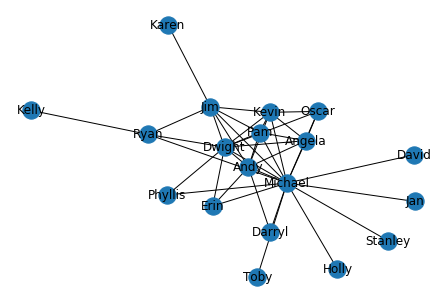

In [8]:
#plot network
nx.draw(G,with_labels = True)

## Plotting network metrics per season

Q: Plot Michael's neighbors subgraph per season.

NetworkXError: The node Michael is not in the graph.

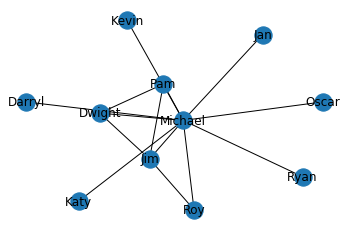

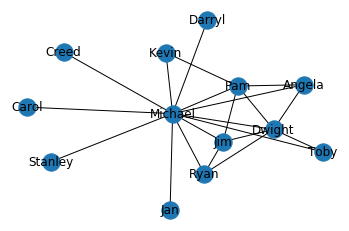

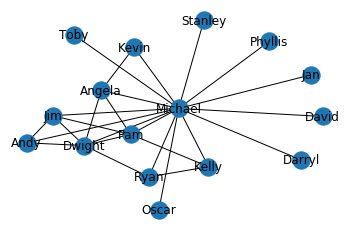

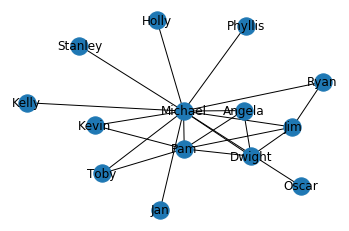

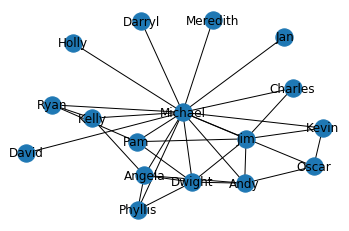

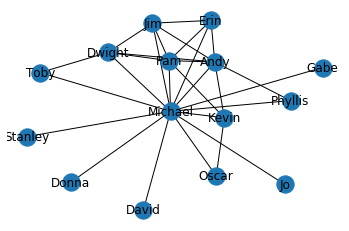

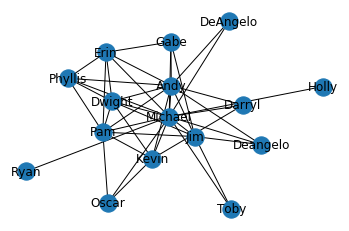

In [9]:
for ssn in np.arange(1,10):
    
    ## build network per season
    data = co_df[co_df['season']==ssn].groupby(['speaker1','speaker2'])['interaction_factor'].sum()\
                .reset_index(name='total_interaction_factor')
    threshold = data['total_interaction_factor'].quantile(0.85)
    network_data = data[data['total_interaction_factor']>threshold]
    G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2',\
                                 edge_attr='total_interaction_factor')
    Gsub= G.subgraph(list(G.neighbors('Michael'))+['Michael'])
    
    #plot
    fig,ax = plt.subplots()
    nx.draw(Gsub,with_labels = True)

>Q: Quantify how the sitcom network changed over the seasons using the average shortest path length metric

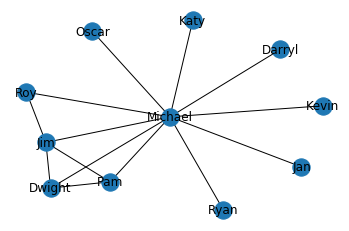

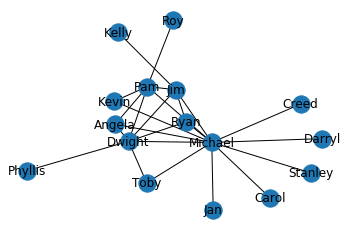

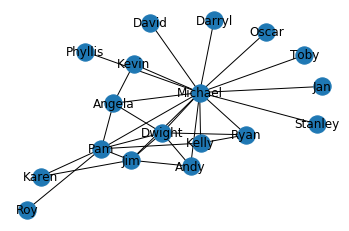

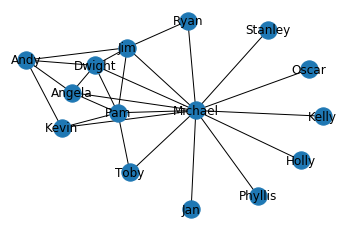

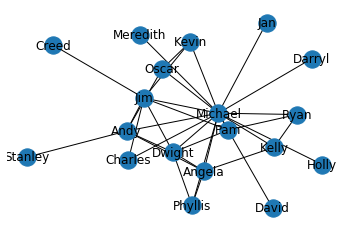

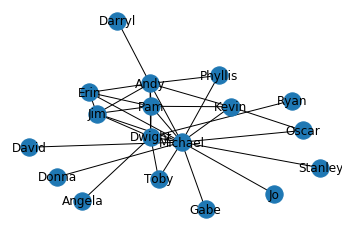

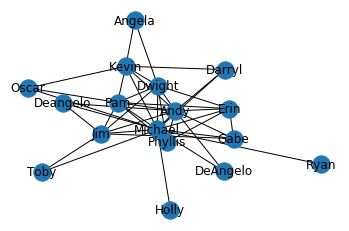

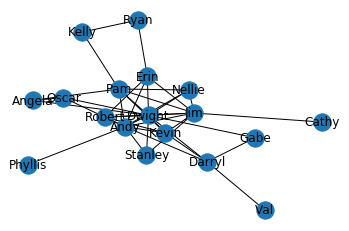

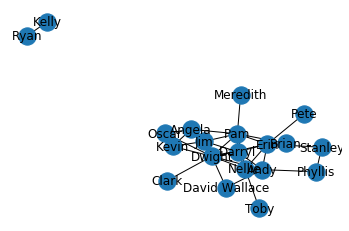

In [10]:
for ssn in np.arange(1,10):
    
    ## build network per season
    data = co_df[co_df['season']==ssn].groupby(['speaker1','speaker2'])['interaction_factor'].sum()\
                .reset_index(name='total_interaction_factor')
    threshold = data['total_interaction_factor'].quantile(0.85)
    network_data = data[data['total_interaction_factor']>threshold]
    G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2',\
                                 edge_attr='total_interaction_factor')
    
    #plot
    fig,ax = plt.subplots()
    nx.draw(G,with_labels = True)

In [14]:
for ssn in np.arange(1,10):
    data = co_df[co_df['season']==ssn].groupby(['speaker1','speaker2'])['interaction_factor'].sum()\
                .reset_index(name='total_interaction_factor')
    
    #use quantiles to get a threshold
    threshold = data['total_interaction_factor'].quantile(0.85)
    network_data = data[data['total_interaction_factor']>threshold]
    G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2',\
                                 edge_attr='total_interaction_factor')
    #########################################
    #get largest connected component
    Gl_nodes = sorted(nx.connected_components(G), key=len, reverse=True)[0]
    Gl = G.subgraph(Gl_nodes)
    ##############################################
    #plot
    print(('Season %d average path length: %s') % (ssn,nx.average_shortest_path_length(Gl)))
 

Season 1 average path length: 1.7454545454545454
Season 2 average path length: 2.0
Season 3 average path length: 1.934640522875817
Season 4 average path length: 1.8285714285714285
Season 5 average path length: 1.9298245614035088
Season 6 average path length: 1.973856209150327
Season 7 average path length: 1.7205882352941178
Season 8 average path length: 1.9803921568627452
Season 9 average path length: 2.084967320261438


Q: Plot Michael. Dwight, Jim and Pam's eigenvector centrality per season.

In [15]:
bc_dfs=[]
for ssn in np.arange(1,10):
    data = co_df[co_df['season']==ssn].groupby(['speaker1','speaker2'])['interaction_factor'].sum()\
                .reset_index(name='total_interaction_factor')
    
    #use quantiles to get a threshold
    threshold = data['total_interaction_factor'].quantile(0.85)
    network_data = data[data['total_interaction_factor']>threshold]
    G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2',\
                                 edge_attr='total_interaction_factor')
    
    bc_df = pd.DataFrame(nx.eigenvector_centrality(G).items(), columns=['character','eigenvector_c'])
    bc_df['season']=ssn
    bc_dfs.append(bc_df)
 

In [16]:
all_bc_df = pd.concat(bc_dfs)
all_bc_df

,character,eigenvector_c,season
0,Darryl,0.156628,1
1,Michael,0.603127,1
2,Dwight,0.355180,1
3,Pam,0.355180,1
4,Jim,0.409387,1
...,...,...,...
15,Meredith,0.063429,9
16,Nellie,0.329991,9
17,Toby,0.057750,9
18,Phyllis,0.064386,9


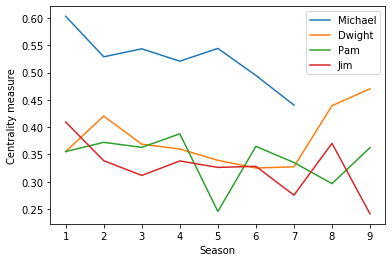

In [17]:
fig,ax = plt.subplots()
for character in ['Michael','Dwight','Pam','Jim']:
    x= all_bc_df[all_bc_df['character']==character]['season'].values
    y= all_bc_df[all_bc_df['character']==character]['eigenvector_c'].values
    plt.plot(x,y, label=character)
    plt.xlabel("Season")
    plt.ylabel("Centrality measure")
plt.legend()

>Q: Which set of characters would most likely cluster together and could be recast in a spinoff series?

In [18]:
for ssn in np.arange(1,10):
    data = co_df[co_df['season']==ssn].groupby(['speaker1','speaker2'])['interaction_factor'].sum()\
                .reset_index(name='total_interaction_factor')
    
    #use quantiles to get a threshold
    threshold = data['total_interaction_factor'].quantile(0.85)
    network_data = data[data['total_interaction_factor']>threshold]
    G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2',\
                                 edge_attr='total_interaction_factor')
    
    #extract cliques per season and get the largest
    season_cliques = list(nx.algorithms.clique.enumerate_all_cliques(G))
    #get largest clique size
    max_size_clique = max([len(x) for x in season_cliques])
    #filter season cliques that match largest clique size
    largest_season_cliques = [x for x in season_cliques if len(x)==max_size_clique]
    print(('Season %d: %s') % (ssn,largest_season_cliques))
 

Season 1: [['Michael', 'Dwight', 'Pam', 'Jim']]
Season 2: [['Angela', 'Dwight', 'Michael', 'Pam'], ['Dwight', 'Michael', 'Pam', 'Jim'], ['Dwight', 'Michael', 'Ryan', 'Jim']]
Season 3: [['Angela', 'Dwight', 'Michael', 'Pam'], ['Dwight', 'Michael', 'Pam', 'Jim'], ['Dwight', 'Michael', 'Andy', 'Jim']]
Season 4: [['Angela', 'Dwight', 'Michael', 'Pam'], ['Dwight', 'Michael', 'Pam', 'Jim']]
Season 5: [['Andy', 'Angela', 'Dwight', 'Michael'], ['Andy', 'Dwight', 'Michael', 'Jim'], ['Angela', 'Dwight', 'Michael', 'Phyllis'], ['Dwight', 'Michael', 'Pam', 'Jim']]
Season 6: [['Andy', 'Erin', 'Pam', 'Michael', 'Jim'], ['Andy', 'Pam', 'Dwight', 'Michael', 'Jim']]
Season 7: [['Andy', 'Erin', 'Pam', 'Dwight', 'Michael', 'Phyllis']]
Season 8: [['Andy', 'Erin', 'Dwight', 'Jim', 'Robert'], ['Andy', 'Pam', 'Dwight', 'Jim', 'Kevin'], ['Andy', 'Pam', 'Dwight', 'Jim', 'Nellie'], ['Andy', 'Dwight', 'Jim', 'Robert', 'Kevin']]
Season 9: [['Andy', 'Erin', 'Dwight', 'Darryl', 'Nellie'], ['Erin', 'Dwight', 'Pam', 

## Network modifications

>Q: What would the sitcom network look like if Pam was removed from the show? Plot the resulting graphs per season.

Two approaches:

    1. remove Pam as a node in the graph (much like Thanos' snap in Avengers: Endgame)
    
    2. remove all entries of Pam in the co-occurence table

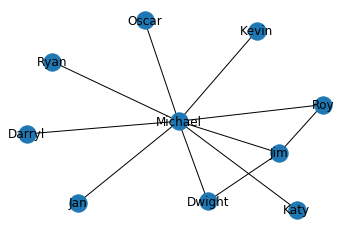

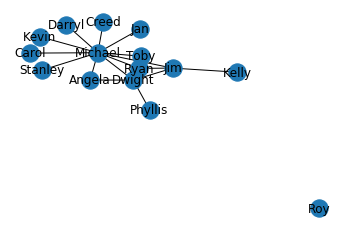

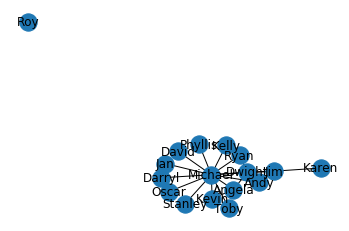

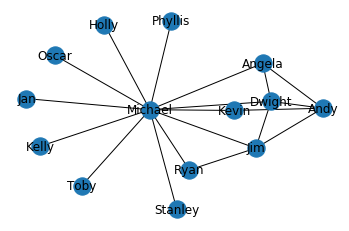

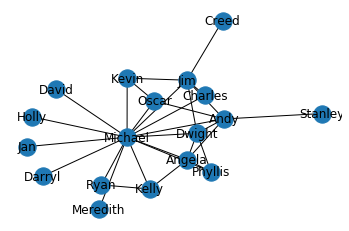

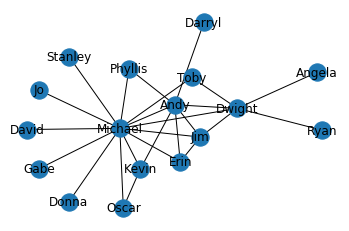

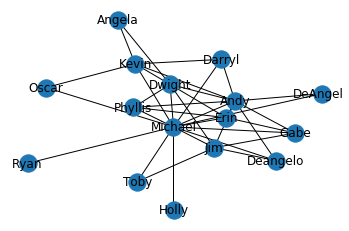

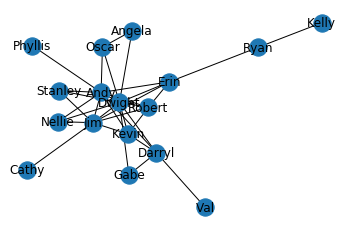

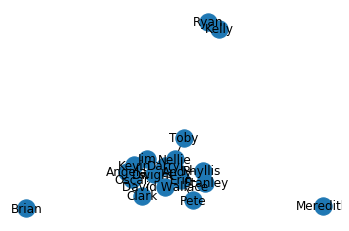

In [19]:
#Remove Pam as a node in the graph
for ssn in np.arange(1,10):
    data = co_df[(co_df['season']==ssn)].groupby(['speaker1','speaker2'])['interaction_factor'].sum()\
                .reset_index(name='total_interaction_factor')
    threshold = data['total_interaction_factor'].quantile(0.85)
    network_data = data[data['total_interaction_factor']>threshold]
    
    G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2',\
                                 edge_attr='total_interaction_factor')
    #remove Pam's node
    G.remove_node("Pam")
    fig,ax = plt.subplots()
    nx.draw(G,with_labels = True)

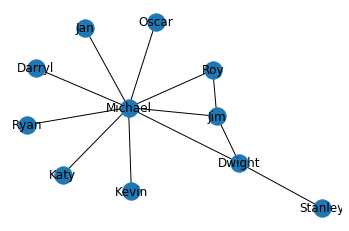

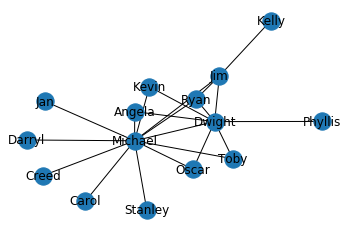

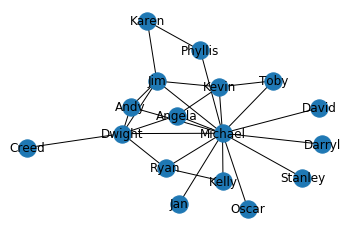

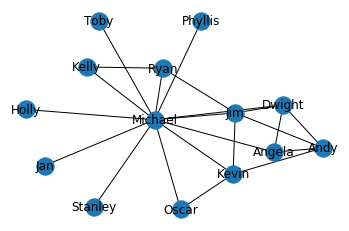

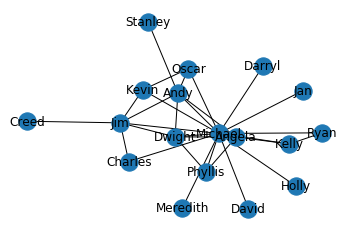

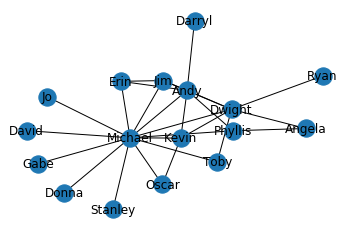

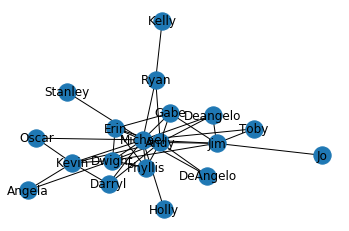

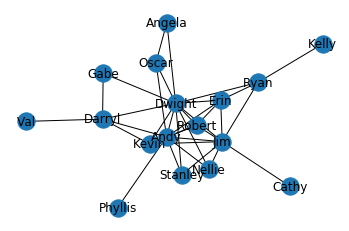

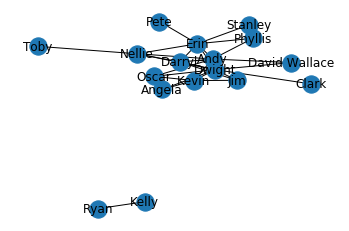

In [20]:
#Remove Pam's entries in co-occurrence table
for ssn in np.arange(1,10):
    #remove Pam
    #both for speaker1 and speaker2
    data = co_df[(co_df['season']==ssn)&(co_df['speaker1']!="Pam")&(co_df['speaker2']!="Pam")]\
                .groupby(['speaker1','speaker2'])['interaction_factor'].sum()\
                .reset_index(name='total_interaction_factor')
    threshold = data['total_interaction_factor'].quantile(0.85)
    network_data = data[data['total_interaction_factor']>threshold]
    
    
    G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2',\
                                 edge_attr='total_interaction_factor')

    fig,ax = plt.subplots()
    nx.draw(G,with_labels = True)

>Q: In this Pam-less universe, plot Michael, Dwight, Jim eigenvector centrality per season and compare these values with the unaltered sitcom network

In [21]:
bc_dfs2=[]
for ssn in np.arange(1,10):
    #remove Pam
    #both for speaker1 and speaker2
    data = co_df[(co_df['season']==ssn)&(co_df['speaker1']!="Pam")&(co_df['speaker2']!="Pam")]\
                .groupby(['speaker1','speaker2'])['interaction_factor'].sum()\
                .reset_index(name='total_interaction_factor')
    threshold = data['total_interaction_factor'].quantile(0.85)
    network_data = data[data['total_interaction_factor']>threshold]
    
    #compute centrality df
    G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2',\
                                 edge_attr='total_interaction_factor')
    
    bc_df = pd.DataFrame(nx.eigenvector_centrality(G).items(), columns=['character','eigenvector_c'])
    bc_df['season']=ssn
    bc_dfs2.append(bc_df)


In [22]:
all_bc_df2 =pd.concat(bc_dfs2)
all_bc_df2

,character,eigenvector_c,season
0,Darryl,0.191933,1
1,Michael,0.646020,1
2,Dwight,0.335075,1
3,Jim,0.382248,1
4,Roy,0.305499,1
...,...,...,...
12,Kevin,0.283607,9
13,Nellie,0.297327,9
14,Toby,0.055005,9
15,Phyllis,0.157590,9


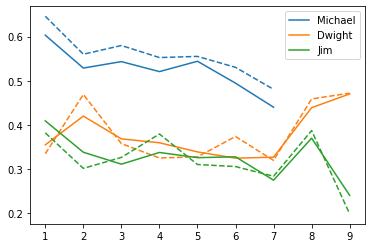

In [23]:
#line charts to compare unaltered vs altered sitcom network metric
fig,ax = plt.subplots()

#loop over all characters of interest:
for n,character in enumerate(['Michael','Dwight','Jim']):
    #unaltered
    x= all_bc_df[all_bc_df['character']==character]['season'].values
    y= all_bc_df[all_bc_df['character']==character]['eigenvector_c'].values
    #plot as dashed line
    plt.plot(x,y, label=character, color="C"+str(n))
    
    #altered
    x= all_bc_df2[all_bc_df2['character']==character]['season'].values
    y= all_bc_df2[all_bc_df2['character']==character]['eigenvector_c'].values
    #plot as dashed line
    plt.plot(x,y, ls='--', color="C"+str(n))
    
plt.legend()

# More modifications

### Increase `this_character`'s interactions by a factor of 3

In [26]:
bc_dfs3=[]

this_character = "Kelly"

for ssn in np.arange(1,10):
    #####################################
    data = co_df[co_df['season']==ssn].copy()
    data['interaction_factor'] = data.apply(lambda x: 3*x['interaction_factor']\
                                        if (x['speaker1']==this_character)|(x['speaker2']==this_character)\
                                        else x['interaction_factor'], axis=1)
    
    data = data.groupby(['speaker1','speaker2'])['interaction_factor'].sum()\
                .reset_index(name='total_interaction_factor')
    
    ####################################
    
    threshold = data['total_interaction_factor'].quantile(0.85)
    network_data = data[data['total_interaction_factor']>threshold]
    
    #compute centrality df
    G = nx.from_pandas_edgelist(network_data, source='speaker1', target='speaker2',\
                                 edge_attr='total_interaction_factor')
    
    bc_df = pd.DataFrame(nx.eigenvector_centrality(G).items(), columns=['character','eigenvector_c'])
    bc_df['season']=ssn
    bc_dfs3.append(bc_df)


In [27]:
all_bc_df3 =pd.concat(bc_dfs3)
all_bc_df3

,character,eigenvector_c,season
0,Darryl,0.164544,1
1,Michael,0.612458,1
2,Dwight,0.368541,1
3,Pam,0.368541,1
4,Jim,0.390774,1
...,...,...,...
15,Meredith,0.063429,9
16,Nellie,0.329991,9
17,Toby,0.057750,9
18,Phyllis,0.064386,9


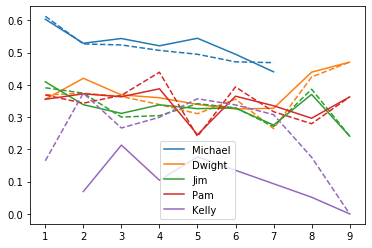

In [28]:
#line charts to compare unaltered vs altered sitcom network metric
fig,ax = plt.subplots()

#loop over all characters of interest:
for n,character in enumerate(['Michael','Dwight','Jim','Pam','Kelly']):
    #unaltered
    x= all_bc_df[all_bc_df['character']==character]['season'].values
    y= all_bc_df[all_bc_df['character']==character]['eigenvector_c'].values
    #plot as dashed line
    plt.plot(x,y, label=character, color="C"+str(n))
    
    #altered
    x= all_bc_df3[all_bc_df3['character']==character]['season'].values
    y= all_bc_df3[all_bc_df3['character']==character]['eigenvector_c'].values
    #plot as dashed line
    plt.plot(x,y, ls='--', color="C"+str(n))
    
plt.legend()

In [ ]:
#decrease this_character interactions by a factor of 3 (multiply by 1/3)
data['interaction_factor'] = data.apply(lambda x: 0.3333*x['interaction_factor']\
                                        if (x['speaker1']==this_character)|(x['speaker2']==this_character)\
                                        else x['interaction_factor'], axis=1)

In [ ]:
#Increase the interactions of 2 characters by a factor of 3
characters=[character1,character2]
data['interaction_factor'] = data.apply(lambda x: 3*x['interaction_factor']\
                                        if (x['speaker1'].isin(characters))|(x['speaker2'].isin(characters))\
                                        else x['interaction_factor'], axis=1)

In [ ]:
#Increase character1's interactions by a factor of 3 AND decrease  character2's interactions by a factor of 3
data['interaction_factor'] = data.apply(lambda x: 3*x['interaction_factor'] \
                                        if (x['speaker1']==character1)|(x['speaker2']==character1)\
                                        else x['interaction_factor'], axis=1)
data['interaction_factor'] = data.apply(lambda x: 0.33*x['interaction_factor']\
                                        if (x['speaker1']==character2)|(x['speaker2']==character2)\
                                        else x['interaction_factor'], axis=1)